# Model Building and Training

In [ ]:
import pandas as pd 
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from mlflow import *
from mlflow.sklearn import *
from collections import Counter

import matplotlib.pyplot as plt
plt.ioff()
from scipy.special import expit as sigmoid
from sklearn.model_selection import StratifiedShuffleSplit
%matplotlib inline 

# To save the model
import joblib

pd.set_option('display.max_columns', 100)

In [15]:
import os
import sys
sys.path.append(os.path.join(os.path.abspath('..')))

In [16]:
# Import modules
from src import data_loading as dl
from scripts.model_building_and_evaluation import *
from scripts.mdel_explainability import *

In [17]:
# Load the dataset
fraud_data_with_country = dl.load_data('cleaned/fraud_data_preprocessed.csv') # Loading fraud dataset

## 1. Data Balancing 

In [ ]:
print('No frauds', round(fraud_data_with_country['class'].value_counts()[0]/len(fraud_data_with_country) * 100,2),
      '% of the dataset')
print('Frauds', round(fraud_data_with_country['class'].value_counts()[1]/len(fraud_data_with_country) * 100,2),
      '% of the dataset')

No frouds 90.5 % of the dataset
Frouds 9.5 % of the dataset


In [19]:
# Split the data into features (X) and target (y)
X = fraud_data_with_country.drop('class', axis=1)
y = fraud_data_with_country['class']

# Create a StratifiedShuffleSplit object with 5 splits and a test size of 0.2
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data into training and testing sets
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Convert the data to numpy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [20]:
# Check the distribution of labels in the training and testing sets
train_unique_label, train_counts_label = np.unique(y_train, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_test, return_counts=True)

print('-' * 100)
print('Label Distributions: \n')
print('Training set label distribution:', train_counts_label/ len(y_train))
print('Testing set label distribution:', test_counts_label/ len(y_test))

----------------------------------------------------------------------------------------------------
Label Distributions: 

Training set label distribution: [0.90500987 0.09499013]
Testing set label distribution: [0.90499419 0.09500581]


## 1.1 Random Under-Sampling

**Overview**
In this phase, we’ll implement "Random Under-Sampling" to balance our dataset and prevent model overfitting.

**Steps:**
1. **Assess Class Imbalance:** Use value_counts() on the 'class' column to gauge the imbalance.

2. **Balancing Classes:** Equalize the number of fraud (Fraud = 1) and non-fraud (Fraud = 0) transactions. For a 50/50 ratio, match the number of non-fraud cases (116,878) to the number of fraud cases (12,268), resulting in 12,268 cases of each class.

3. **Shuffle Data:** Post balancing, shuffle the dataset to ensure consistent model performance across runs.

**Note:**
Random Under-Sampling might reduce the accuracy of our models due to significant information loss, as we're shrinking the dataset from 116,878 non-fraudulent transactions to just 12,268. Therefore, while it ensures balance, it might impact the richness of the training data.

In [21]:
non_fraud_sum = fraud_data_with_country[fraud_data_with_country['class'] == 0].value_counts().sum()
print(non_fraud_sum)

116878


In [22]:
fraud_sum = fraud_data_with_country[fraud_data_with_country['class'] == 1].value_counts().sum()
print(fraud_sum)

12268


In [23]:
# To address the class imbalance issue, we'll undersample the majority class
# to match the number of instances in the minority class.

# Randomly shuffle the entire dataset to ensure randomness
df = fraud_data_with_country.sample(frac=1, random_state=42).reset_index(drop=True)

# Isolate the minority class (fraud) with 12,268 instances
minority_class = df.loc[df['class'] == 1]

# Select a random subset of the majority class (non-fraud) with the same number of instances as the minority class
majority_class_subset = df.loc[df['class'] == 0].sample(n=12268, random_state=42)

# Combine the minority class and the majority class subset to create a balanced dataset
balanced_df = pd.concat([minority_class, majority_class_subset])

# Shuffle the balanced dataset to ensure randomness
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the first few rows of the balanced dataset
balanced_df.head()

,purchase_value,class,signup_time_hour,signup_time_day,signup_time_year,signup_time_month,purchase_time_hour,purchase_time_day,purchase_time_year,purchase_time_month,transaction_count,user_activity_period_days,transaction_velocity,avg_purchase,time_to_purchase,seconds_since_signup,quick_purchase,sex_F,sex_M,country_Afghanistan,country_Albania,country_Algeria,country_Angola,country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Australia,country_Austria,country_Azerbaijan,country_Bahamas,country_Bahrain,country_Bangladesh,country_Barbados,country_Belarus,country_Belgium,country_Belize,country_Benin,country_Bermuda,country_Bhutan,country_Bolivia,country_Bonaire; Sint Eustatius; Saba,country_Bosnia and Herzegowina,country_Botswana,country_Brazil,country_British Indian Ocean Territory,country_Brunei Darussalam,country_Bulgaria,country_Burkina Faso,country_Burundi,country_Cambodia,...,country_Reunion,country_Romania,country_Russian Federation,country_Rwanda,country_Saint Kitts and Nevis,country_Saint Martin,country_San Marino,country_Saudi Arabia,country_Senegal,country_Serbia,country_Seychelles,country_Singapore,country_Slovakia (SLOVAK Republic),country_Slovenia,country_South Africa,country_South Sudan,country_Spain,country_Sri Lanka,country_Sudan,country_Sweden,country_Switzerland,country_Syrian Arab Republic,country_Taiwan; Republic of China (ROC),country_Tajikistan,country_Tanzania United Republic of,country_Thailand,country_Trinidad and Tobago,country_Tunisia,country_Turkey,country_Turkmenistan,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe,age_group_18-24,age_group_25-34,age_group_35-44,age_group_45-54,age_group_55-64,age_group_65+
0,0.629630,1,0.000000,-0.50,0.0,-0.75,0.000000,-0.50,0.0,-1.25,0.0,0.0,0.0,0.629630,-0.901525,-0.901525,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.407407,0,0.909091,0.25,0.0,-0.75,0.545455,-0.25,0.0,-0.50,0.0,0.0,0.0,0.407407,0.613741,0.613741,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.740741,1,-0.181818,-0.25,0.0,0.25,0.545455,-0.75,0.0,0.25,0.0,0.0,0.0,-0.740741,0.178948,0.178948,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.666667,0,-0.636364,-0.25,0.0,-0.50,0.363636,0.50,0.0,-0.25,0.0,0.0,0.0,0.666667,0.482091,0.482091,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.555556,1,0.636364,-0.75,0.0,-0.50,-0.818182,0.75,0.0,-1.00,0.0,0.0,0.0,-0.555556,-0.817437,-0.817437,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

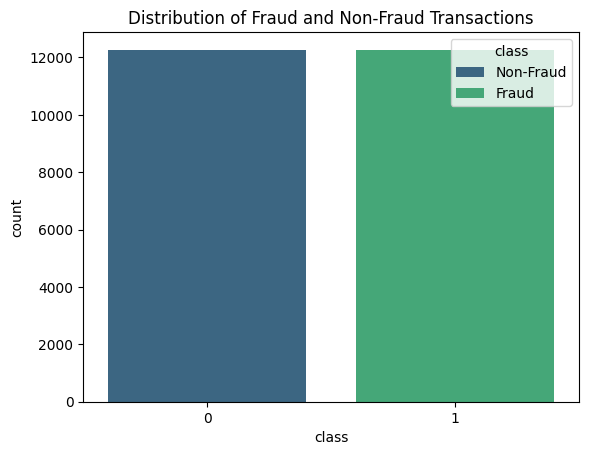

In [24]:
sns.countplot(data=balanced_df, x='class', hue='class', palette='viridis')
plt.legend(title='class', labels=['Non-Fraud', 'Fraud'], loc='best')
plt.title('Distribution of Fraud and Non-Fraud Transactions')
plt.show()

class                                  1.000000
quick_purchase                         0.609565
purchase_time_day                      0.032696
country_Tunisia                        0.030677
country_Denmark                        0.027330
                                         ...   
country_South Sudan                         NaN
country_Tajikistan                          NaN
country_Tanzania United Republic of         NaN
country_Vanuatu                             NaN
country_Yemen                               NaN
Name: class, Length: 206, dtype: float64


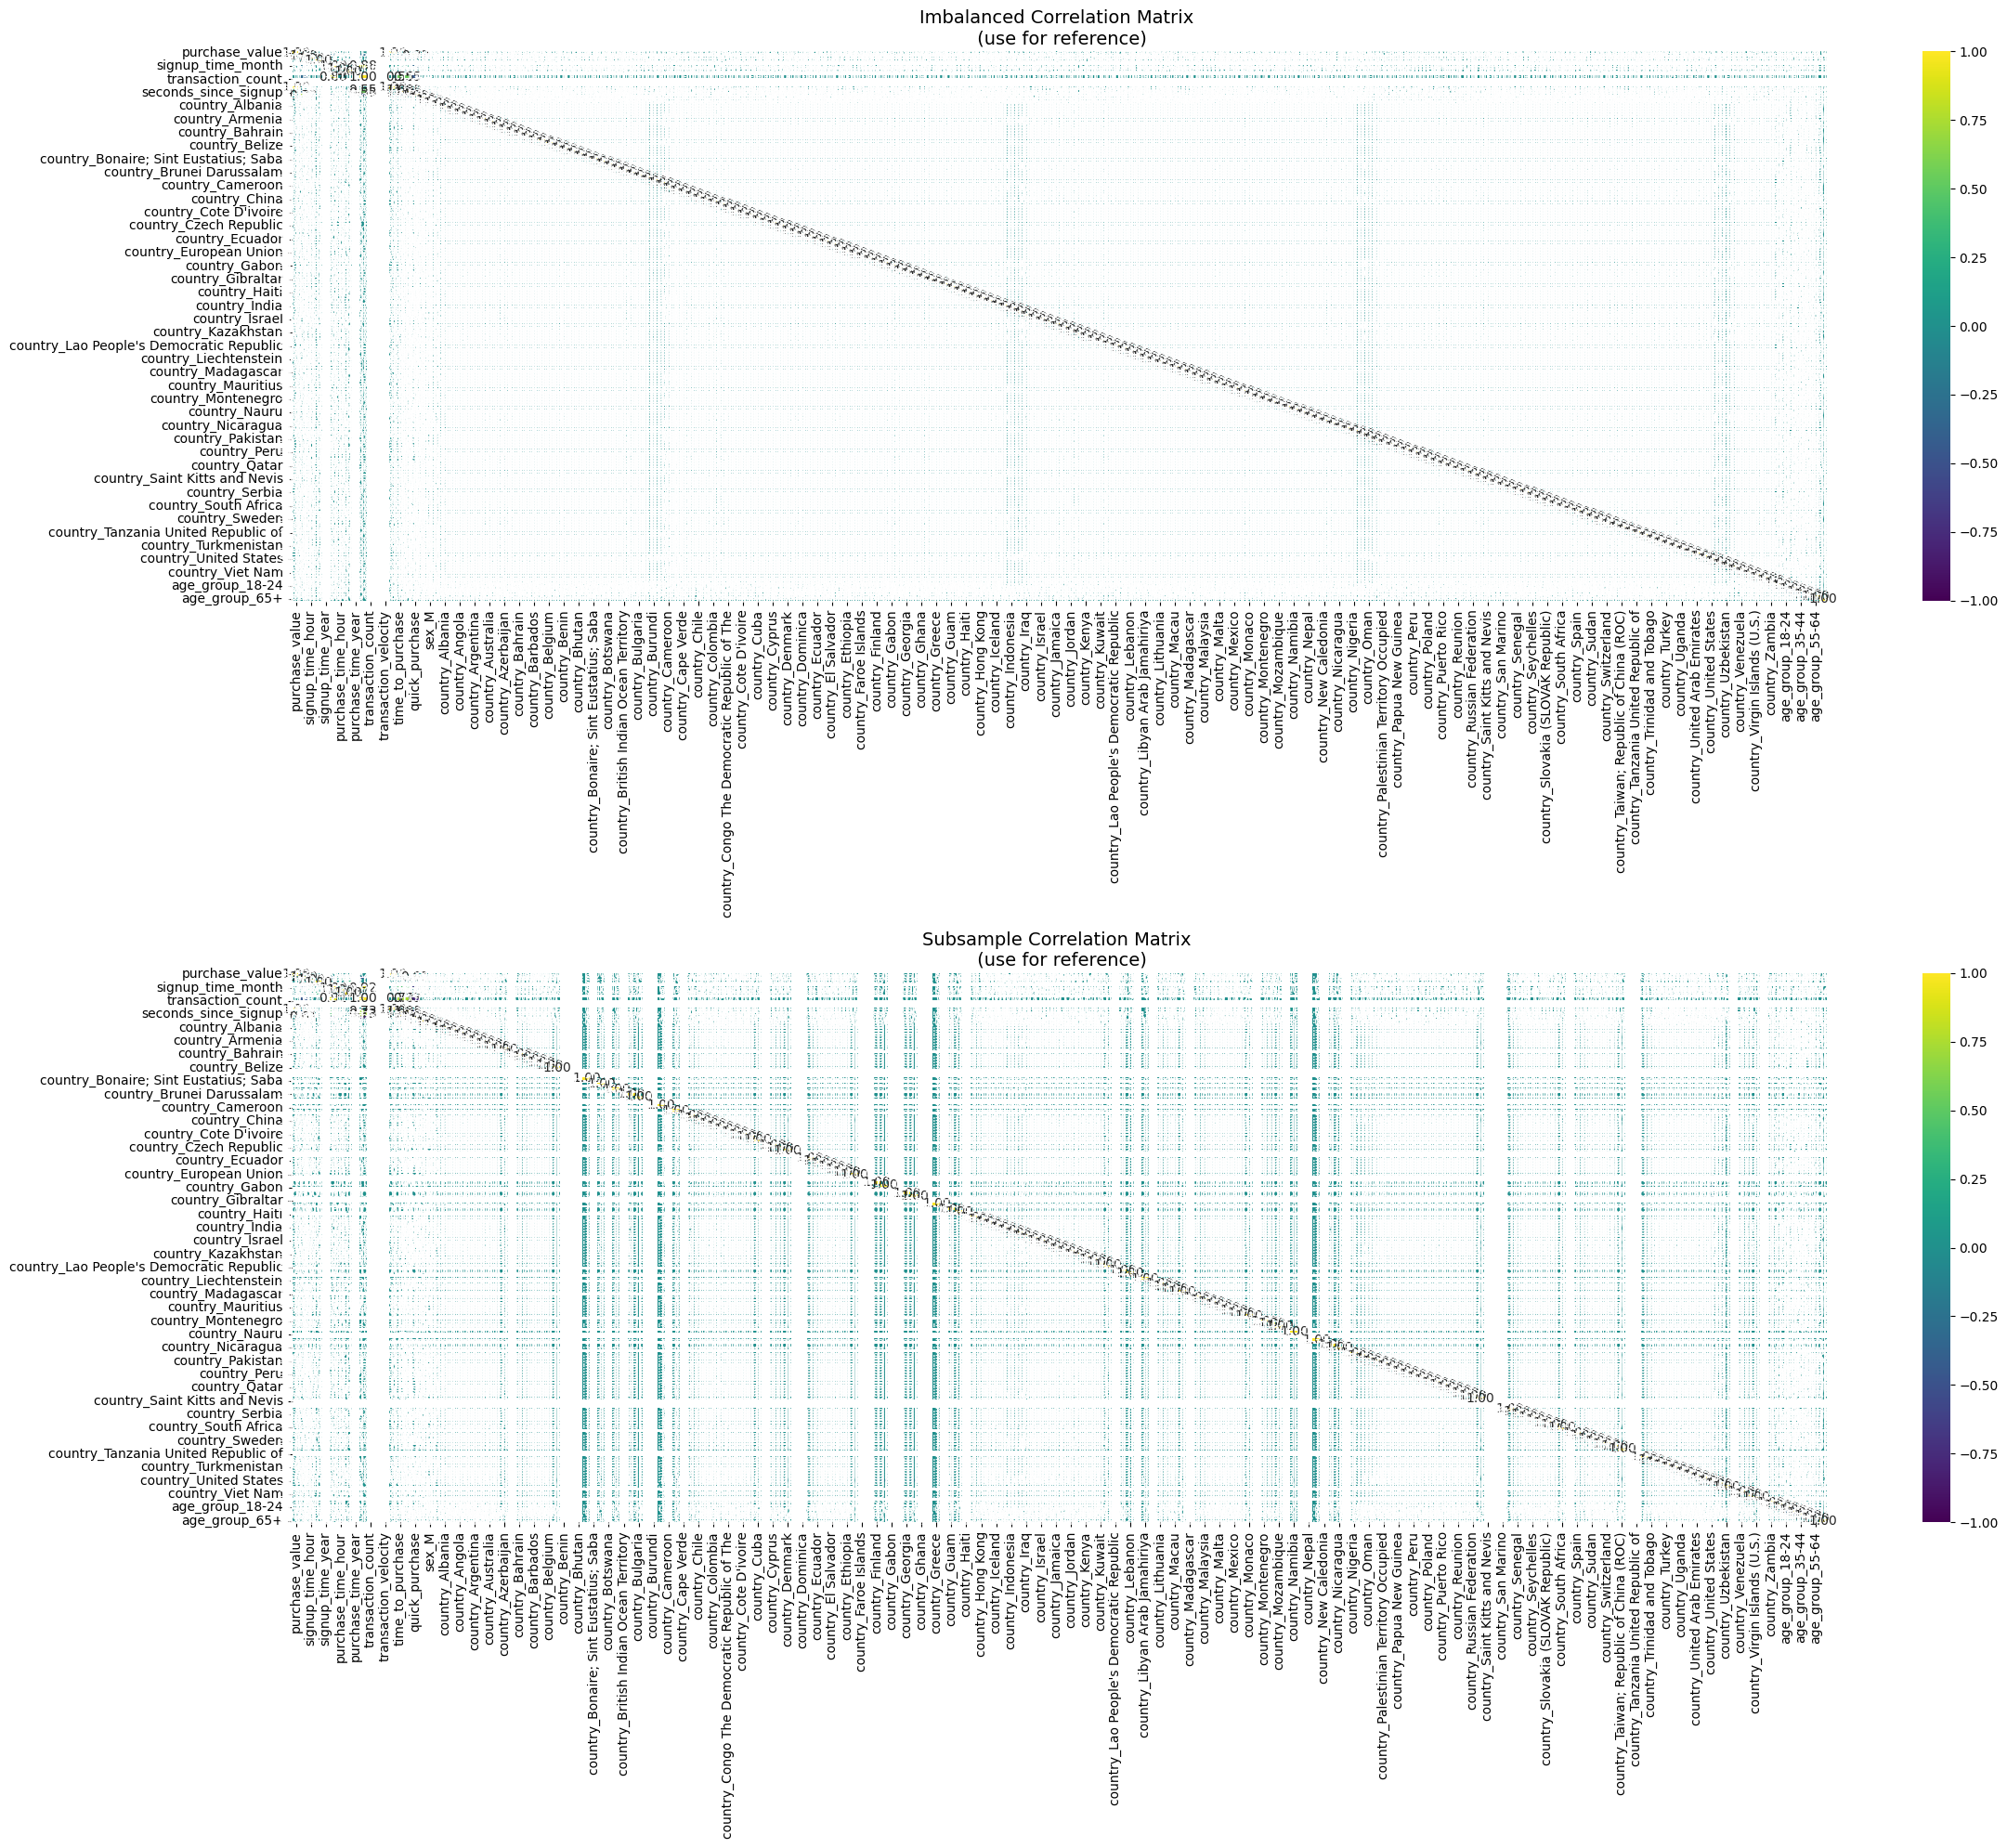

In [25]:
# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(24, 20))

# Calculate the correlation matrix for the imbalanced dataset
correlation_matrix_imbalanced = fraud_data_with_country.corr(numeric_only=True)

# Calculate the correlation matrix for the balanced dataset
correlation_matrix_balanced = balanced_df.corr(numeric_only=True)

# Plot the correlation heatmap for the imbalanced dataset
sns.heatmap(correlation_matrix_imbalanced, ax=axes[0], cmap='viridis', annot=True, fmt=".2f")
axes[0].set_title('Imbalanced Correlation Matrix \n (use for reference)', fontsize=14)

# Plot the correlation heatmap for the balanced dataset
sns.heatmap(correlation_matrix_balanced, ax=axes[1], cmap='viridis', annot=True, fmt=".2f")
axes[1].set_title('Subsample Correlation Matrix \n (use for reference)', fontsize=14)

# Extract and sort correlations for the class column in the balanced dataset
class_corr = correlation_matrix_balanced['class'].sort_values(ascending=False)
print(class_corr)

# Show the plots
plt.tight_layout()
plt.show()

In [26]:
# Features and Target
X = balanced_df.drop('class', axis=1)
y = balanced_df['class']

In [27]:
#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [29]:
# Model selection
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'MLP': MLPClassifier(),
    'CNN': Sequential([
        Reshape((X.shape[1], 1)),
        Conv1D(32, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ]),
    'RNN': Sequential([
        Reshape((X.shape[1], 1)),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ]),
    'LSTM': Sequential([
        Reshape((X.shape[1], 1)),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
}

In [ ]:
# Compile the models
for model_name, model in models.items():
    if isinstance(model, Sequential):
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Using logistic regression and random forest let's check how the method perfrom

Logistic Regression
Cross Validation Score:  77.17%
ROC_AUC Score :  76.84%


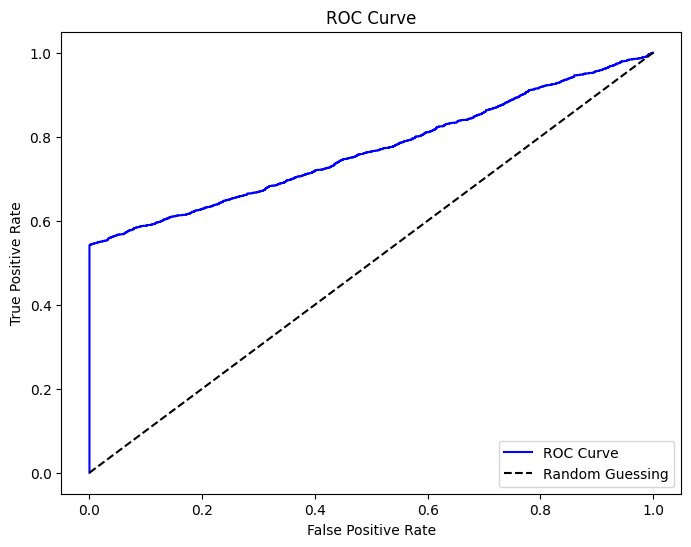

              precision    recall  f1-score   support

           0       0.68      1.00      0.81      2433
           1       1.00      0.54      0.70      2475

    accuracy                           0.77      4908
   macro avg       0.84      0.77      0.76      4908
weighted avg       0.84      0.77      0.76      4908





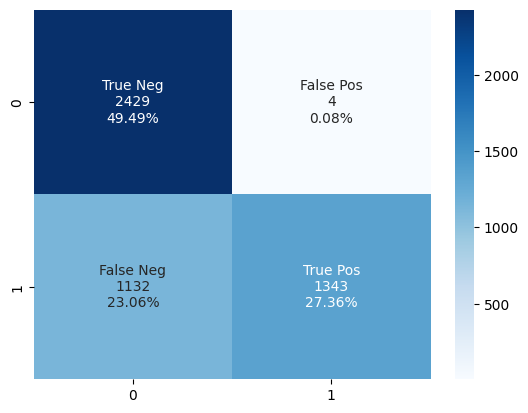

In [31]:
# Call Logistic Regression
models_lr = models['Logistic Regression']
print("Logistic Regression")
cross_validation_score(models_lr, X_train, y_train)
model_other(models_lr, X_train, y_train, X_test, y_test)
model_evaluation(models_lr, X_test, y_test)
print("\n")

Random Forest
Cross Validation Score:  77.00%
ROC_AUC Score :  77.43%


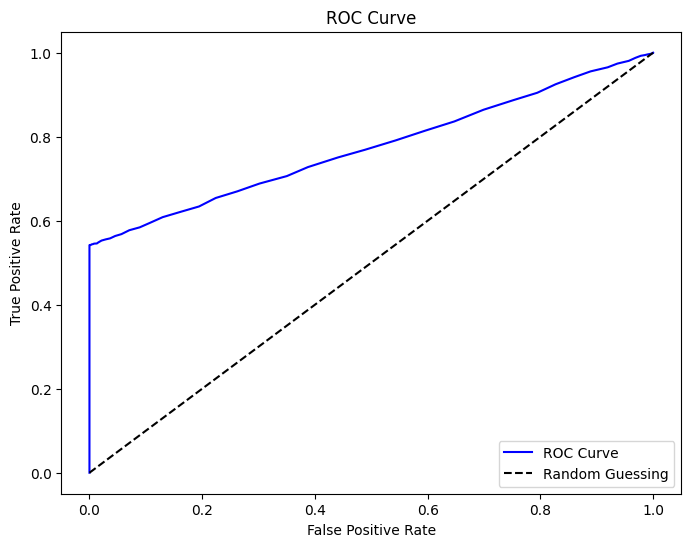

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      2433
           1       0.98      0.55      0.70      2475

    accuracy                           0.76      4908
   macro avg       0.83      0.77      0.75      4908
weighted avg       0.83      0.76      0.75      4908





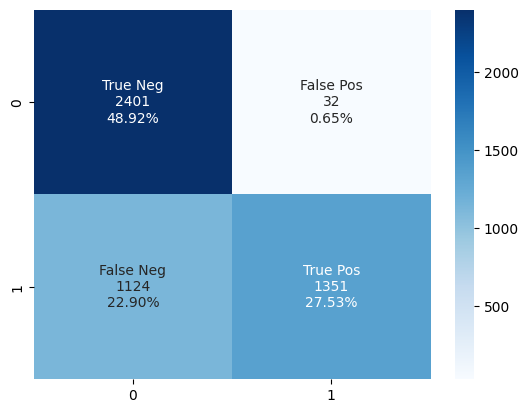

In [33]:
model_rf = models['Random Forest']
print("Random Forest")
cross_validation_score(model_rf, X_train, y_train)
model_other(model_rf, X_train, y_train, X_test, y_test)
model_evaluation(model_rf, X_test, y_test)
print("\n")

The model's accuracy is well but on recall it's highly favorable to no fraud so we have to consider the other options to handle our imbalanced datasets.

#### 1.2 using Anova score with over and under sampling

In [34]:
# Check for constant features
constant_features = fraud_data_with_country.loc[:, fraud_data_with_country.nunique() == 1]
constant_features.columns

Index(['signup_time_year', 'purchase_time_year', 'transaction_count',
       'user_activity_period_days', 'transaction_velocity'],
      dtype='object')

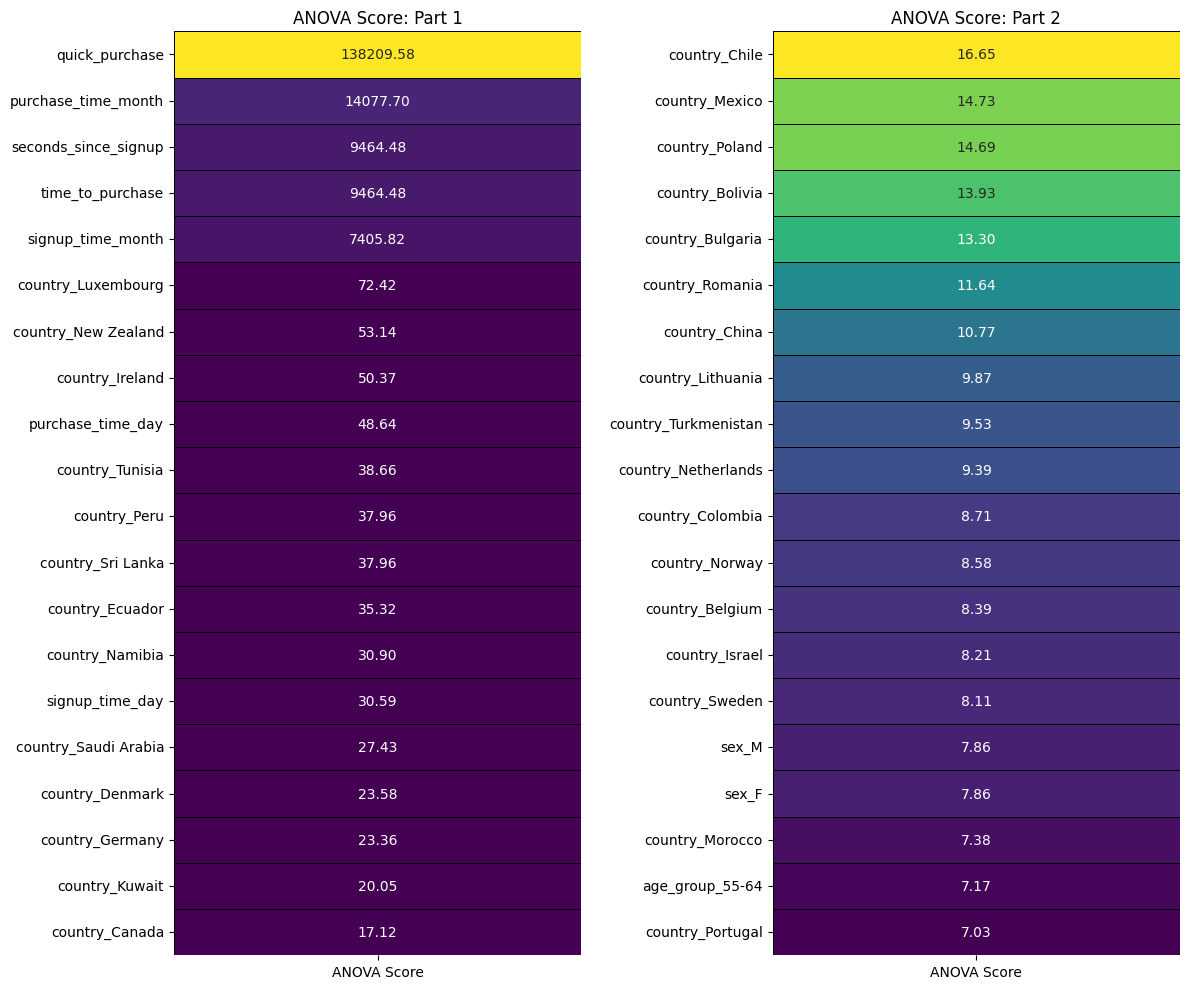

In [35]:
# Prepare features and target
features = fraud_data_with_country.drop(columns=['class', 'signup_time_year', 'purchase_time_year', 
                                                 'transaction_count', 'user_activity_period_days', 
                                                 'transaction_velocity'])
target = fraud_data_with_country['class']

# Select the best features using ANOVA
best_features = SelectKBest(score_func=f_classif, k='all')
fit = best_features.fit(features, target)
feature_scores = pd.DataFrame(data=fit.scores_, index=list(features.columns), columns=['ANOVA Score'])

# Sort the features by their ANOVA Score
feature_scores = feature_scores.sort_values(by='ANOVA Score', ascending=False)

# Plot the ANOVA scores using heatmap
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 10)) # Adjusted figsize for better visualization
plt.subplot(1, 2, 1)
sns.heatmap(feature_scores.iloc[:20, :], annot=True, cmap='viridis', linewidths=0.4, linecolor='black', cbar=False, fmt='.2f')
plt.title('ANOVA Score: Part 1')

plt.subplot(1, 2, 2)
sns.heatmap(feature_scores.iloc[20:40, :], annot=True, cmap='viridis', linewidths=0.4, linecolor='black', cbar=False, fmt='.2f')
plt.title('ANOVA Score: Part 2')

fig.tight_layout(w_pad=2)
plt.show()

In [37]:
# Select the top 9 features with the highest ANOVA scores
df = fraud_data_with_country.copy(deep = True)
df.drop(columns = list(feature_scores.index[9:]),inplace = True)
df.head()

,class,signup_time_year,signup_time_month,purchase_time_day,purchase_time_year,purchase_time_month,transaction_count,user_activity_period_days,transaction_velocity,time_to_purchase,seconds_since_signup,quick_purchase,country_Ireland,country_Luxembourg,country_New Zealand
0,0,0.0,0.50,0.75,0.0,0.50,0.0,0.0,0.0,-0.236689,-0.236689,0.0,0.0,0.0,0.0
1,0,0.0,-0.75,-0.25,0.0,-1.00,0.0,0.0,0.0,-0.676087,-0.676087,0.0,0.0,0.0,0.0
2,0,0.0,-0.25,0.50,0.0,-0.50,0.0,0.0,0.0,-0.535899,-0.535899,0.0,0.0,0.0,0.0
3,0,0.0,-0.50,0.50,0.0,-0.25,0.0,0.0,0.0,0.497056,0.497056,0.0,0.0,0.0,0.0
4,0,0.0,0.75,-0.50,0.0,1.25,0.0,0.0,0.0,0.974546,0.974546,0.0,0.0,0.0,0.0


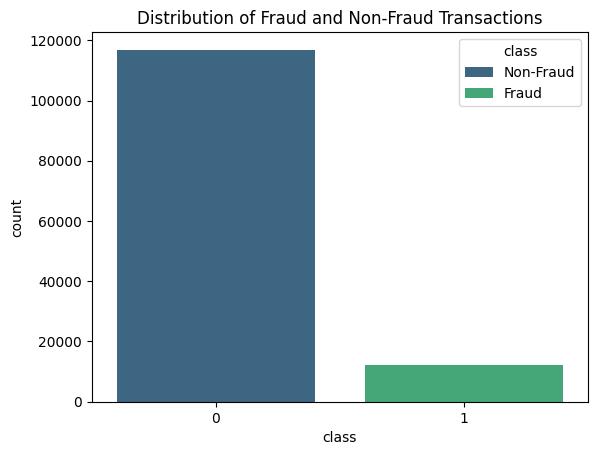

In [38]:
sns.countplot(data=df, x='class', hue='class', palette='viridis')
plt.legend(title='class', labels=['Non-Fraud', 'Fraud'], loc='best')
plt.title('Distribution of Fraud and Non-Fraud Transactions')
plt.show()

In [39]:
# Define the resampling strategies
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.2)

# Split data into features (X) and target (y)
# Split data into features (X) and target (y)
X_anova = df.iloc[:, 1:].values  # Select all columns except the first for features
y_anova = df.iloc[:, 0].values  # Select the first column for the target


# Apply under-sampling first
X_under, y_under = under.fit_resample(X_anova, y_anova)

# Apply over-sampling on the under-sampled data
X_resampled2, y_resampled2 = over.fit_resample(X_under, y_under)

# Now you can use the resampled data for further processing
print(Counter(y_resampled2))

Counter({0: 61340, 1: 30670})


In [40]:
# Model selection
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'MLP': MLPClassifier(),
    'CNN': Sequential([
        Reshape((X_anova.shape[1], 1)),
        Conv1D(32, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ]),
    'RNN': Sequential([
        Reshape((X_anova.shape[1], 1)),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ]),
    'LSTM': Sequential([
        Reshape((X_anova.shape[1], 1)),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
}

In [41]:
# Compile the models
for model_name, model in models.items():
    if isinstance(model, Sequential):
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled2, y_resampled2, test_size=0.2, random_state=42)

Let's evaluate how the logistic regression and random forest model performs on this methods 

Logistic Regression
Cross Validation Score:  77.35%
ROC_AUC Score :  77.02%


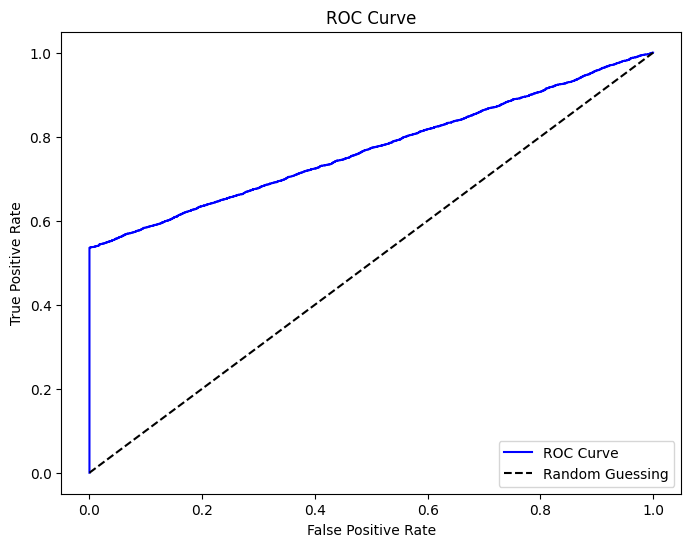

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     12312
           1       1.00      0.54      0.70      6090

    accuracy                           0.85     18402
   macro avg       0.91      0.77      0.80     18402
weighted avg       0.87      0.85      0.83     18402





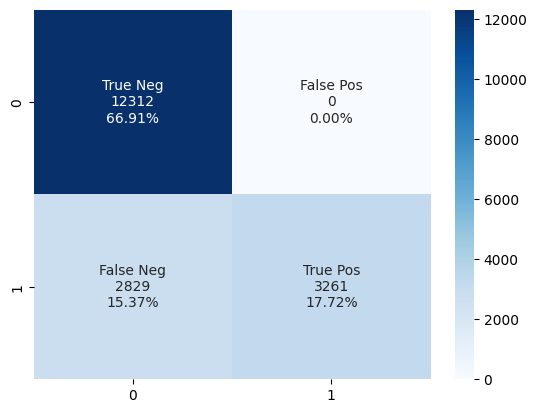

In [43]:
# Call each model separately
models_lr = models['Logistic Regression']
print("Logistic Regression")
cross_validation_score(models_lr, X_train, y_train)
model_other(models_lr, X_train, y_train, X_test, y_test)
model_evaluation(models_lr, X_test, y_test)
print("\n")

Random Forest
Cross Validation Score:  82.68%
ROC_AUC Score :  82.25%


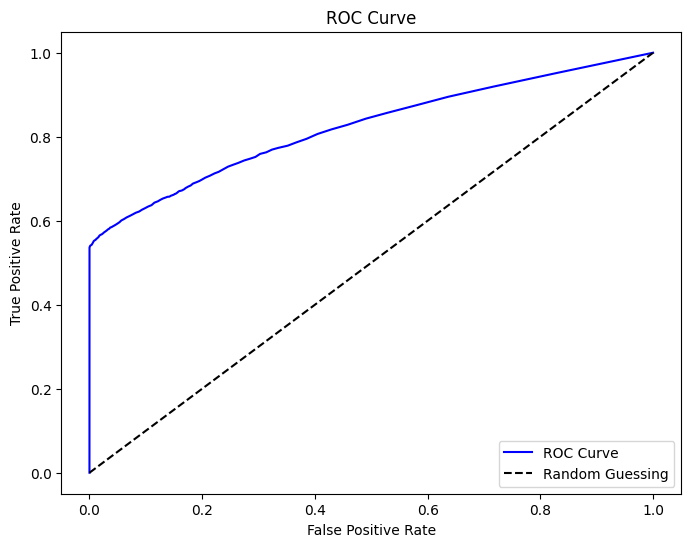

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     12312
           1       0.69      0.66      0.68      6090

    accuracy                           0.79     18402
   macro avg       0.76      0.76      0.76     18402
weighted avg       0.79      0.79      0.79     18402





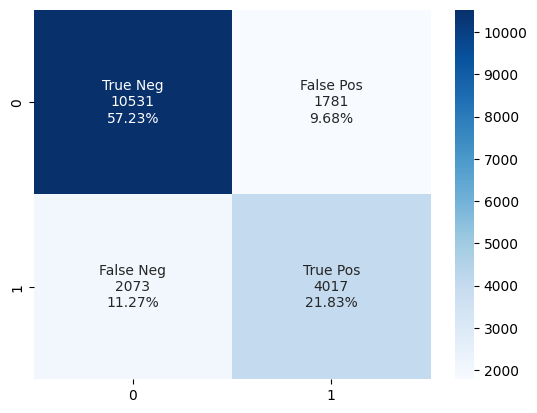

In [44]:
model_rf = models['Random Forest']
print("Random Forest")
cross_validation_score(model_rf, X_train, y_train)
model_other(model_rf, X_train, y_train, X_test, y_test)
model_evaluation(model_rf, X_test, y_test)
print("\n")

After trying ANOVA scores with over and undersampling, the most favorable features were quick purchase and a few others. However, most columns had very low ANOVA scores, so ignoring all these features wouldn't be appropriate. For further accuracy, I’ve decided to handle imbalanced data using over and undersampling only, which should increase our accuracy score.

### 1.3 Combining both undersampling and oversampling selecting all features

In [46]:
# Define the resampling strategies
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.2)

# Split data into features (X) and target (y)
# Split data into features (X) and target (y)
X_u_o = fraud_data_with_country.drop(columns=['class'])
y_u_o = fraud_data_with_country['class']

# Apply under-sampling first
X_under, y_under = under.fit_resample(X_u_o, y_u_o)

# Apply over-sampling on the under-sampled data
X_resampled, y_resampled = over.fit_resample(X_under, y_under)

# Now you can use the resampled data for further processing
print(Counter(y_resampled))

Counter({0: 61340, 1: 30670})


In [54]:
# Model selection
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'MLP': MLPClassifier(max_iter=500),
    'CNN': Sequential([
        Reshape((X_u_o.shape[1], 1)),
        Conv1D(32, kernel_size=3, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ]),
    'RNN': Sequential([
        Reshape((X_u_o.shape[1], 1)),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ]),
    'LSTM': Sequential([
        Reshape((X_u_o.shape[1], 1)),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
}

In [55]:
# Compile the models
for model_name, model in models.items():
    if isinstance(model, Sequential):
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Model Evaluation Metrics

- I've evaluated the models using the following metrics:
1. **Cross-Validation Score:** a measure of the model's performance on unseen data.
2. **ROC-AUC Score:** a measure of the model's ability to distinguish between the positive and negative classes.
3. **Confusion Matrix:** a table that summarizes the model's predictions against the actual labels.

    **Actual Class vs. Predicted Class**

    * **True Negatives (Top-Left):** Correctly classified as "No" (No Fraud Detected)
    * **False Negatives (Top-Right):** Incorrectly classified as "No" (should be "Yes", Fraud Detected)
    * **False Positives (Bottom-Left):** Incorrectly classified as "Yes" (should be "No", No Fraud Detected)
    * **True Positives (Bottom-Right):** Correctly classified as "Yes" (Fraud Detected)

4. **Classification Report:** a report that provides precision, recall, and F1-score for each class.

### 1. Logistic Regression

Logistic Regression
Cross Validation Score:  79.08%
ROC_AUC Score :  79.37%


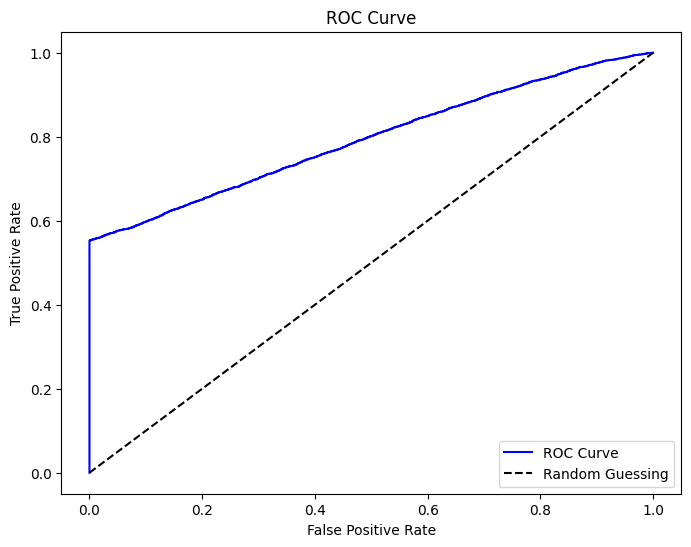

              precision    recall  f1-score   support

           0       0.82      1.00      0.90     12312
           1       1.00      0.55      0.71      6090

    accuracy                           0.85     18402
   macro avg       0.91      0.78      0.81     18402
weighted avg       0.88      0.85      0.84     18402





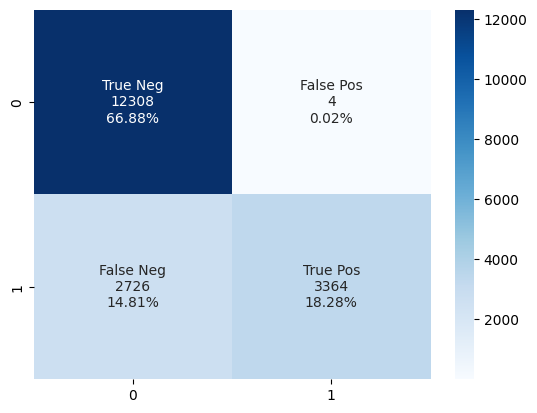

In [50]:
# Call each model separately
models_lr = models['Logistic Regression']
print("Logistic Regression")
cross_validation_score(models_lr, X_train, y_train)
model_other(models_lr, X_train, y_train, X_test, y_test)
model_evaluation(models_lr, X_test, y_test)
print("\n")

In [ ]:
# Explain the evaluated models
print("Explaining Logistic Regression model with SHAP...")
shap_explainability(models_lr, X_train, X_test)

print("Explaining Logistic Regression model with LIME...")
lime_explainability(models_lr, X_train, X_test)

### 2. Decision Tree: 
- a tree-based model that splits the data into subsets based on feature values.

Decision Tree
Cross Validation Score:  85.86%
ROC_AUC Score :  86.13%


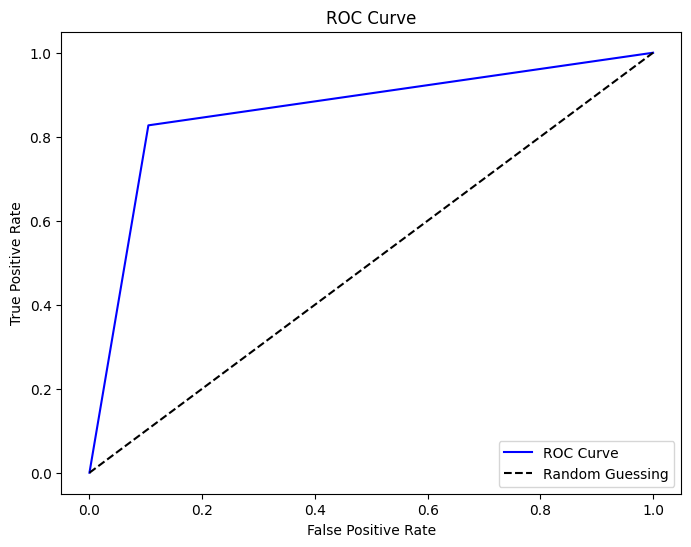

              precision    recall  f1-score   support

           0       0.91      0.90      0.90     12312
           1       0.80      0.83      0.81      6090

    accuracy                           0.87     18402
   macro avg       0.85      0.86      0.86     18402
weighted avg       0.87      0.87      0.87     18402





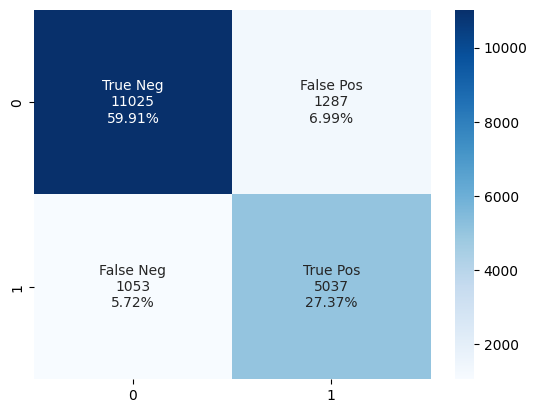

In [52]:
models_dt = models['Decision Tree']
print("Decision Tree")
cross_validation_score(models_dt, X_train, y_train)
model_other(models_dt, X_train, y_train, X_test, y_test)
model_evaluation(models_dt, X_test, y_test)
print("\n")

Explainin Decision Tree model with SHAP...


PermutationExplainer explainer: 18403it [20:56, 14.56it/s]                           


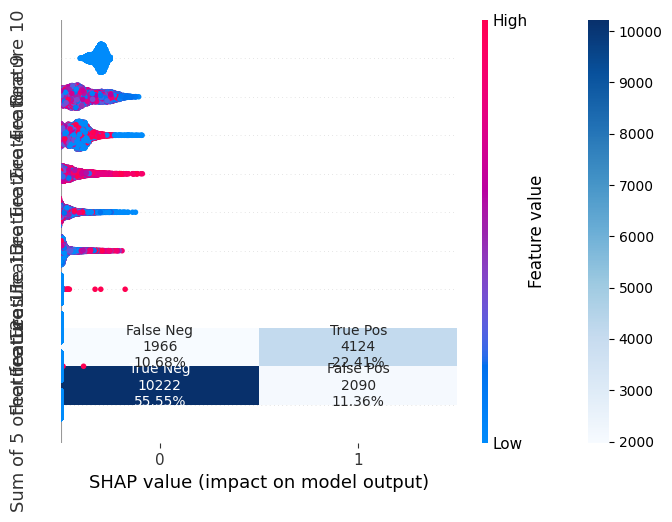

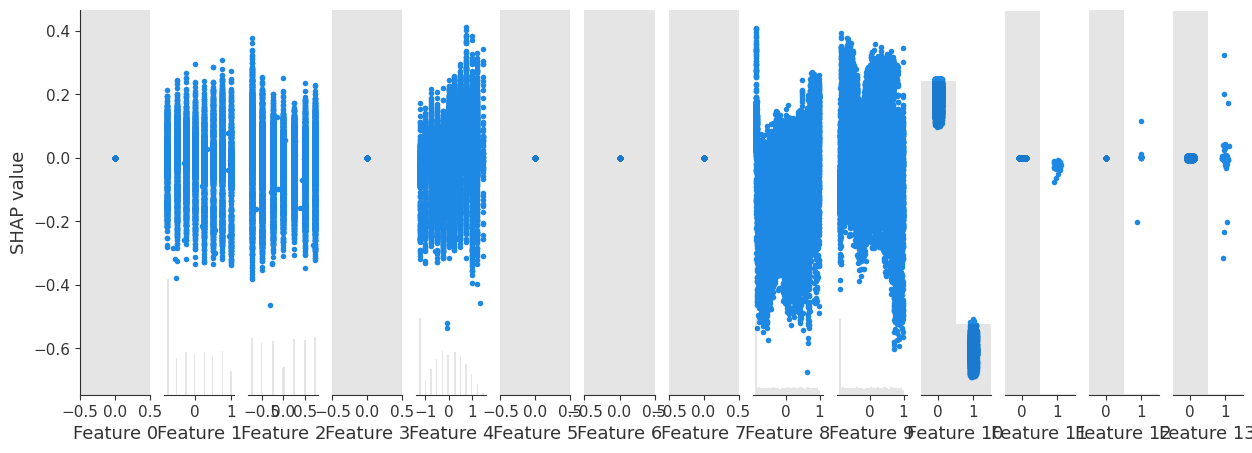

Explaining Decision Tree model with LIME...


In [ ]:
# Explain the evaluated models
print("Explainin Decision Tree model with SHAP...")
shap_explainability(models_dt, X_train, X_test)

print("Explaining Decision Tree model with LIME...")
lime_explainability(models_dt, X_train, X_test)

### 3. Random Forest 

Random Forest
Cross Validation Score:  94.66%
ROC_AUC Score :  94.52%


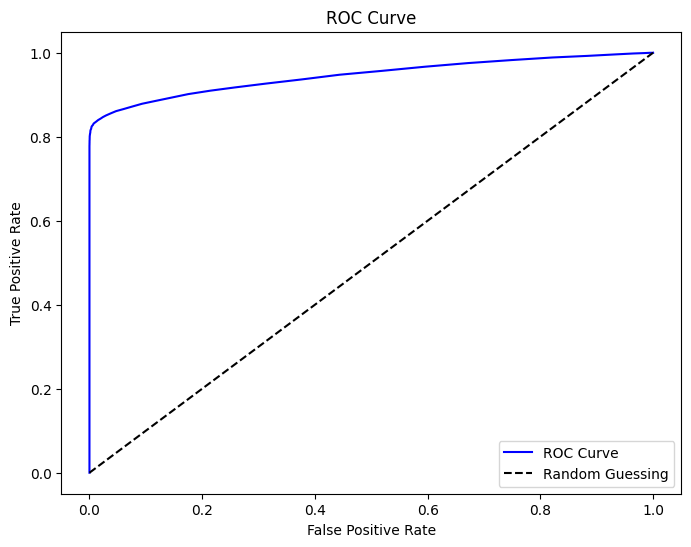

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     12312
           1       1.00      0.78      0.88      6090

    accuracy                           0.93     18402
   macro avg       0.95      0.89      0.91     18402
weighted avg       0.94      0.93      0.93     18402





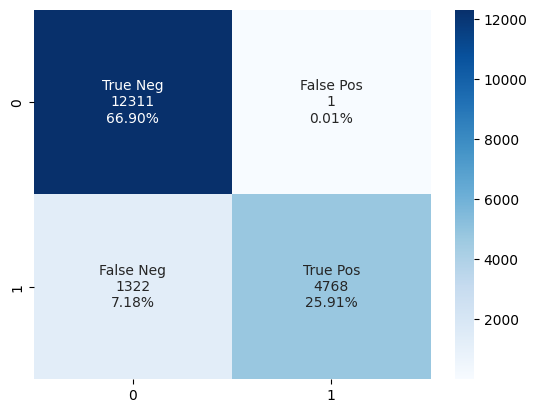

In [53]:
model_rf = models['Random Forest']
print("Random Forest")
cross_validation_score(model_rf, X_train, y_train)
model_other(model_rf, X_train, y_train, X_test, y_test)
model_evaluation(model_rf, X_test, y_test)
print("\n")

In [ ]:
# Explain the evaluated models
print("Explaining Random Forest model with SHAP...")
shap_explainability(model_rf, X_train, X_test)

print("Explaining Random Forest model with LIME...")
lime_explainability(model_rf, X_train, X_test)

### 4. Gradient Boosting 

Gradient Boosting
Cross Validation Score:  90.96%
ROC_AUC Score :  90.78%


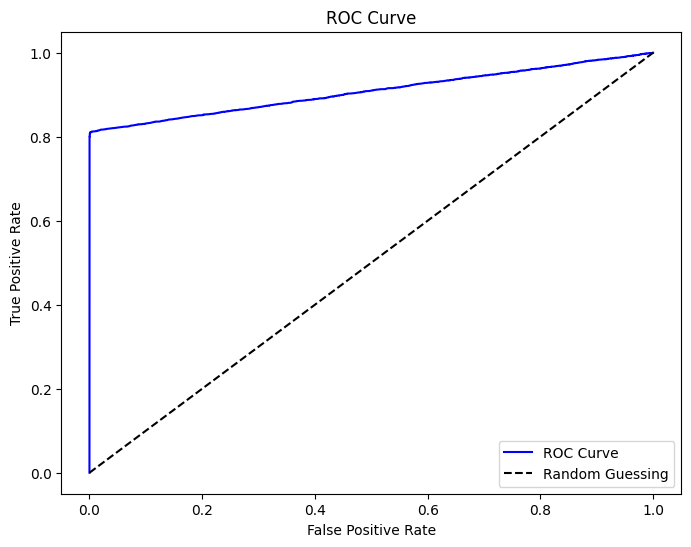

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     12312
           1       1.00      0.78      0.87      6090

    accuracy                           0.93     18402
   macro avg       0.95      0.89      0.91     18402
weighted avg       0.93      0.93      0.92     18402





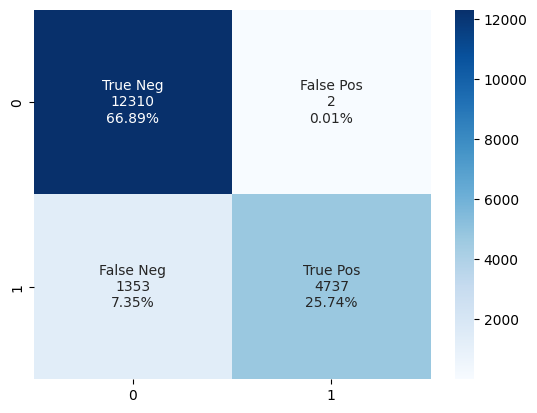

In [57]:
model_gb = models['Gradient Boosting']
print("Gradient Boosting")
cross_validation_score(model_gb, X_train, y_train)
model_other(model_gb, X_train, y_train, X_test, y_test)
model_evaluation(model_gb, X_test, y_test)
print("\n")

In [ ]:
# Explain the evaluated models
print("Explaining Gradient Boosting model with SHAP...")
shap_explainability(model_gb, X_train, X_test)

print("Explaining Gradient Boosting model with LIME...")
lime_explainability(model_gb, X_train, X_test)

### 5. MLP

In [ ]:
model_mlp = models['MLP']
print("MLP")
cross_validation_score(model_mlp, X_train, y_train)
model_other(model_mlp, X_train, y_train, X_test, y_test)
model_evaluation(model_mlp, X_test, y_test)
print("\n")

In [ ]:
# Explain the evaluated models
print("Explaining Multi-Layer Perceptron (MLP) model with SHAP...")
shap_explainability(model_mlp, X_train, X_test)

print("Explaining Multi-Layer Perceptron (MLP) model with LIME...")
lime_explainability(model_mlp, X_train, X_test)

### 6. CNN

In [ ]:
model_cnn = models['CNN']
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("CNN")
model_neural_network(model_cnn, X_train, y_train, X_test, y_test)
model_evaluation(model_cnn, X_test, y_test)
cross_validation_score(model_cnn, X_train, y_train)
print("\n")

In [ ]:
# Explain the evaluated models
print("Explaining Convolutional Neural Network (CNN) model with SHAP...")
shap_explainability_neural(model_cnn, X_train, X_test)

print("Explaining Convolutional Neural Network (CNN) model with LIME...")
lime_explainability_neural(model_cnn, X_train, X_test)

### 7. RNN

In [ ]:
model_rnn = models['RNN']
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("RNN")
model_neural_network(model_rnn, X_train, y_train, X_test, y_test)
model_evaluation(model_rnn, X_test, y_test)
cross_validation_score(model_rnn, X_train, y_train)
print("\n")

In [ ]:
# Explain the evaluated models
print("Explaining Recurrent Neural Network (RNN) model with SHAP...")
shap_explainability(model_rnn, X_train, X_test)

print("Explaining Recurrent Neural Network (RNN) model with LIME...")
lime_explainability_neural(model_rnn, X_train, X_test)

### 8. LSTM 

In [ ]:
model_lstm = models['LSTM']
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("LSTM")
model_neural_network(model_lstm, X_train, y_train, X_test, y_test)
model_evaluation(model_lstm, X_test, y_test)
cross_validation_score(model_lstm, X_train, y_train)
print("\n")

In [ ]:
# Explain the evaluated models
print("Explaining Long Short-Term Memory (LSTM) model with SHAP...")
shap_explainability_neural(model_lstm, X_train, X_test)

print("Explaining Long Short-Term Memory (LSTM) model with LIME...")
lime_explainability_neural(model_lstm, X_train, X_test)

Based on Roc score, Cross Validation Score, ROC_AUC Score, confusion matrix and performance metrics random forest performs the best so we selected this model as the best.

In [ ]:
# Save random forest model 
joblib.dump(model_rf, '../model/fraud_data/random_forest_model.pkl')

Some of these models require high computational capacity, so I left out a few, including SHAP explainability, on this dataset. However, for the credit card data, everything is well addressed.